# 11. Построение простого нестационарного решения уравнения фильтрации

Материалы курсов "Исследования скважин и пластов" и "Гидродинамические исследования скважин" в РГУ нефти и газа имени И.М.Губкина.

Версия 0.3 от 02.11.2021

Хабибуллин Ринат 2021 г.

---


[Открыть на google colab](https://colab.research.google.com/github/khabibullinra/welltest_examples/blob/master/jupyter/11_transient_line_source_solution_Ei.ipynb)    (требуется логин google для работы)

## Содержание:
* [11.1. Простейшие решение нестационарного уравнения фильтрации](#11.1)
    * [11.1.1 Вывод уравнения фильтрации](#11.1.1)
    * [11.1.2 Уравнение фильтрации в безразмерных переменных](#11.1.2)
    * [11.1.3 Решение линейного стока](#11.1.3)
* [11.2 Задания для самостоятельной работы](#11.2)

In [1]:
# импортируем библиотеки для расчетов

# numpy используем для работы с массивами и подготовки данных для построения графиков. 
# Также в некоторых функциях используем возможности векторных расчетов numpy
import numpy as np
# matplotlib используем для построения графиков
import matplotlib.pyplot as plt

# mpmath используем для расчета спец фукнций и математических операций
from mpmath import *
mp.dps = 5;          # здесь задаем желаемую точность расчетов mpmath (количество знаков после запятой)
mp.pretty = True      # здесь задаем вывод функций mpmath в виде чисел а не объетов

# scipy.special используем как альтернативный вариант расчета специальных функций
import scipy.special as sc

Для установившегося режима фильтрации давление в пласте не меняется. Для псевдо-установившегося режима постоянным остается перепад давления между пластом и забоем. После запуска, остановки или изменения режима работы скважины эти условия не выполняются. Давление в различных точках пласта может меняться по разному. Такой режим называют неустановившимся, а решения его описывающие нестационарными (зависят от времени).

# 11.1. Простейшие решение нестационарного уравнения фильтрации <a class="anchor" id="11.1"></a>

Уравнение фильтрации описывает движение жидкости в пористой среде. В отечественной литературе часто называют уравнением пьезопроводности, в зарубежной можно встретить название уравнение диффузии (the diffusivity equation).

## 11.1.1 Вывод уравнения фильтрации <a class="anchor" id="11.1.1"></a>
Уравнение фильтрации основано на трех основных уравнениях
* законе сохранения массы
* зависимости связывающей градиент давления с расходом, в простейшем виде это закон Дарси
* уравнении состояния - зависимости связывающей сжимаемость флюида (и отчасти среды) и давлением

Выпишем эти уравнения, чтобы разобраться. Ориентируемся в обозначениях и подходе на [1]. Особое внимание на данном этапе стоит обратить на размерные коэффициенты в уравнениях. С одной стороны записывая уравнения в [СИ] их можно упростить и избежать части сложностей с переводными коэффициентами. С другой стороны во многих источниках переводные коэффициенты интесивно используются и это оказывается удобно при программной реализации алгоритмов. В данном описании ориентируясь на [1] приведем перевод коэффициентов в практические метрические единицы.

### Закон сохранения массы

В дифференциальной форме, для потока в направлении $x$

$$
-f \dfrac{\partial \rho q_x}{\partial x} = A \dfrac{\partial(\rho \phi)}{\partial t} 
\tag{11.1}
\label{11.1}
$$

где 
* $f$ - размерный коэффициент, для практических метрических единиц $f= 0.04167$, для американских промысловых $f = 0.23394$
* $\rho$ - плотность флюида, кг/м$^3$, lbm/ft$^3$
* $q_x$ - объемный расход в направлении $x$, м$^3$/сут, bbl/day, учитываем для практических метрических единиц $1$ м$^3$/сут $= 0.04167$ м$^3$/час и для промысловых американских  $1$ bbl/day $= 0.23394$ ft$^3$/hr  
* x - координата, м, ft
* $\phi$ - пористость, доли единиц
* $t$ - время, часы
* $A$ - площадь, м$^2$, ft$^2$ 

В перечне указаны размерности для промысловых метрических и американских промысловых единиц измерений, там где они отличаются.

Для практических метрических единиц \eqref{11.1} можно записать в виде
$$
-0.04167 \dfrac{ \partial (\rho q_x) }{\partial x} = A \dfrac{\partial(\rho \phi)}{\partial t} 
\tag{11.2}
\label{11.2}
$$


### Закон Дарси

Простейшим вариантом задания зависимости между измением давления и потоком флюида является линейная зависимость - закон Дарси. При этом линейный множитель в зависимости - функция как коллектора (проницаемость), так и свойств флюида (вязкость).

Закон Дарси в направлении $x$.
$$ 
q_x = -  \dfrac{k_x A}{f\mu} \dfrac{\partial p}{\partial x} 
\tag{11.3}
\label{11.3}
$$

где 
* $f$ - размерный коэффициент, для практических метрических единиц $f= 115.74$, для американских промысловых $f = 887.2$
* $k_x$ - проницаемость в направлении движения потока, мД
* $A$ - площадь, м$^2$, ft$^2$ 
* $\mu$ - динамическая вязкость, сП
* $p$ - давление, атм, psi
* $x$ - координата движения потока, м

В практических метрических единицах измерения \eqref{11.3} будет иметь вид
$$ 
q_x = -  \dfrac{k_x A}{115.74\mu} \dfrac{\partial p}{\partial x} 
\tag{11.4}
\label{11.4}
$$

Пытаясь проверить корректность вывода переводных коэффициентов необходимо учесть что для единиц измерение СИ получим $f=1$, а необходимые переводные коэффициенты можно записать как:
* $q$: $1$ [м$^3$/сек] = $543439$ [bbl/day] = $86400$ [м$^3$/сут]
* $k$: $1$ [м$^2$] = $1.01325 \cdot 10^{15}$ [мД]
* $\mu$: $1$ [Па$\cdot$с] = $1000$ [сП]
* $p$: $1$ [Па] = $0.0001450$ [psi] = $0.00000987$ [атм] 
* $x$: $1$ [м] = $3.28$ [ft] 
* $A$: $1$ [м$^2$] = $10.76$ [ft$^2$]

### Уравнение состояния
В простейшем варианте, который мы будет изучать, предполагается, что сжимаемость постоянна и мала 

$$
c_t = c_{formation} + c_{fluid} = const
\tag{11.5}
\label{11.5}
$$

* $c_t$ - общая сжимаемость (total compressibility)
* $c_{formation}$ - сжимаемость породы (formation compressibility),  $c_{formation} = \dfrac{1}{\phi}\dfrac{\partial \phi}{\partial p}$
* $c_{fluid}$ - сжимаемость флюида (fluid compressibility), $c_{fluid} = \dfrac{1}{\rho}\dfrac{\partial \rho}{\partial p}$

### Уравнение фильтрации
Подставим выражение для закона Дарси \eqref{11.4} в уравнение мат баланса  \eqref{11.2}

$$ 
0.04167 \dfrac{ \partial}{\partial x} { \left[ \rho   \dfrac{k_x A}{115.74\mu} \dfrac{\partial p}{\partial x} \right] } = A \dfrac{\partial(\rho \phi)}{\partial t}  
\tag{11.6}
\label{11.6}
$$

Упрощая \eqref{11.6} получим

$$ 
\frac{\partial (\rho \phi)}{\partial t} = 0.00036 k_x \dfrac{ \partial}{\partial x}\left[ \dfrac{\rho}{\mu}\dfrac{\partial p}{\partial x} \right] 
\tag{11.7}
\label{11.7}
$$

Уравнение \eqref{11.7} подходит для потока газа. Для жидкости, предполагая малую сжимаемость флюида можно его упростить до вида

$$ 
\frac{\partial p}{\partial t} = 0.00036 \dfrac{k_x}{\phi \mu c_t} \dfrac{ \partial^2 p}{\partial x^2} 
\tag{11.8}
\label{11.8}
$$

Напомним, здесь
* $p$ - давление, атм
* $t$ - время, час
* $k_x$ - проницаемость в направлении движения потока, мД
* $\mu$ - динамическая вязкость, сП
* $\phi$ - пористость, д.е.
* $c_t$ - сжимаемость, 1/атм
* $x$ - расстояние, м

Приведенное уравнение \eqref{11.8} соответствует линейному потоку в пласте. Практический интерес представляет решение для радиального потока

$$ 
\frac{\partial p}{\partial t} = 0.00036 \dfrac{k}{\phi \mu c_t} \dfrac{1}{r} \left[ \dfrac{\partial}{\partial r} \left( r \dfrac{ \partial p} {\partial r} \right) \right]  
\tag{11.9}
\label{11.9}
$$

Напомним, здесь
* $p$ - давление, атм
* $t$ - время, час
* $k_x$ - проницаемость в направлении движения потока, мД
* $\mu$ - динамическая вязкость, сП
* $\phi$ - пористость, д.е.
* $c_t$ - сжимаемость, 1/атм
* $r$ - расстояние от центра, м

## 11.1.2 Уравнение фильтрации в безразмерных переменных  <a class="anchor" id="11.1.2"></a>

Часто для анализа уравнений неустановившейся фильтрации используются безразмерные переменные. Мы будем использовать переменные в виде:

$$ r_D = \frac{r}{r_w} \tag{11.10} $$
$$ t_D = \frac{0.00036 kt}{\phi \mu c_t r_w^2}  \tag{11.11}$$
$$ p_D = \frac{kh}{ 18.41 q_s B \mu} \left( p_i - p \right)  \tag{11.12} $$

Здесь использование единицы измерения СИ.
* $r_w$ - радиус скважины, м
* $r$ - расстояние от центра скважины до точки в пласте, м
* $q_s$ - дебит скважины на поверхности, приведенный к нормальным условиям м3/сут
* $\phi$ - пористость, доли единиц
* $\mu$ - вязкость нефти в пласте, сП
* $B$ - объемный коэффициент нефти, м3/м3
* $p_i$ - начальное давление в пласте, атм
* $p$ - давление на расстоянии $r$, атм
* $c_t$ - общая сжимаемость системы в пласте, 1/атм



In [2]:
# определим функции для перевода размерных переменных в безразмерные и обратно
# пригодится потом для построения графиков и ведения расчетов

# при наименовании функций придерживаемся следующих соглашений
# сначала идет название того, что считаем
# в конце указывается размерность результата, если это уместно

def r_from_rd_m(rd, rw_m=0.1):
    """
    перевод безразмерного расстояния в размерное
    rd -  безразмерное расстояние
    rw_m -  радиус скважины, м
    """
    return rd*rw_m

def rd_from_r(r_m, rw_m=0.1):
    """
    перевод размерного расстояния в безразмерное
    r_m - размерное расстояние, м
    rw_m - радиус скважины, м
    """
    return r_m/rw_m

def t_from_td_hr(td, k_mD=10, phi=0.2, mu_cP=1, ct_1atm=1e-5, rw_m=0.1):
    """
    перевод безразмерного времени в размерное, результат в часах
    td - безразмерное время
    k_mD - проницаемость пласта, мД
    phi - пористость, доли единиц
    mu_cP - динамическая вязкость флюида, сП
    ct_1atm - общая сжимаемость, 1/атм
    rw_m - радиус скважины, м
    """
    return td * phi * mu_cP * ct_1atm * rw_m * rw_m / k_mD / 0.00036

def td_from_t(t_hr, k_mD=10, phi=0.2, mu_cP=1, ct_1atm=1e-5, rw_m=0.1):
    """
    перевод размерного времени в безразмерное
    t_hr - размерное время, час
    k_mD - проницаемость пласта, мД
    phi - пористость, доли единиц
    mu_cP - динамическая вязкость флюида, сП
    ct_1atm - общая сжимаемость, 1/атм
    rw_m - радиус скважины, м
    """
    return  0.00036 * t_hr * k_mD / (phi * mu_cP * ct_1atm * rw_m * rw_m) 

def p_from_pd_atma(pd, k_mD=10, h_m=10, q_sm3day=20, b_m3m3=1.2, mu_cP=1, pi_atma=250):
    """
    перевод безразмерного давления в размерное, результат в абсолютных атмосферах
    pd - безразмерное давление
    k_mD - проницаемость пласта, мД
    h_m - мощность пласта, м
    q_sm3day - дебит на поверхности, м3/сут в с.у.
    fvf_m3m3 - объемный коэффициент нефти, м3/м3
    mu_cP - динамическая вязкость флюида, сП
    pi_atma - начальное давление, абсолютные атм.
    """
    return pi_atma - pd * 18.41 * q_sm3day * b_m3m3 * mu_cP / k_mD / h_m 

def pd_from_p(p_atma, k_mD=10, h_m=10, q_sm3day=20, b_m3m3=1.2, mu_cP=1, pi_atma=250):
    """
    перевод размерного давления в безразмерное
    p_atma - давление
    k_mD - проницаемость пласта, мД
    h_m - мощность пласта, м
    q_sm3day - дебит на поверхности, м3/сут в с.у.
    fvf_m3m3 - объемный коэффициент нефти, м3/м3
    mu_cP - динамическая вязкость флюида, сП
    pi_atma - начальное давление, абсолютные атм.
    """
    return (pi_atma - p_atma) / (18.41 * q_sm3day * b_m3m3 * mu_cP) * k_mD * h_m 

Использование безразмерных переменных позволяет упростить уравнение фильтрации (11.9), которое примет вид

$$ 
\frac{\partial p_D}{ \partial t_D} = \dfrac{1}{r_D} \left[ \dfrac{\partial}{\partial r_D} \left( r_D \dfrac{ \partial p_D} {\partial r_D} \right) \right] 
\tag{11.13}
$$

Решение этого уравнения - функция безразмерного давления от безразмерных времени и расстояния $p_D(r_D, t_D) $


## 11.1.3 Решение линейного стока  <a class="anchor" id="11.1.3"></a>
Для решения уравнения фильтрации - линейного дифференциального уравнения в частных производных второго порядка необходимо задать начальные и граничные условия.
Самое простое решение можно получить для случая вертикальной скважины бесконечно малого радиуса запускающейся с постоянным дебитом. Условия соответствующие этому случаю можно выразить следующим образом

* начальное условие. До запуска скважины в момент времени  $t_D = 0$ давление в пласте равно начальному во всех точках $p=p_i$
$$ t_D < 0, p_D = 0 \tag{11.14}$$

* условие постоянства дебита на скважине - граничное условие на скважине
$$ \lim_{r_D \to 0} {r_D \frac{\partial p_D}{\partial r_D}} = -1  \tag{11.15}$$

* условие на бесконечном расстоянии возмущения от скважине нет
$$ r_D = \infty, p_D = 0  \tag{11.16}$$

В этом случае решение может быть выражено через функцию интегральной экспоненты
$$ p_D(r_D,t_D) = - \frac{1}{2} Ei \left(- \dfrac{ r_D^2}{4t_d} \right)  \tag{11.17}$$

где -Ei(-x) - интегральная показательная функция.

$$Ei(x)=-\int\limits_{x}^{\infty}\frac{e^{-t}}{t}\,\mathrm dt=\gamma+\operatorname{ln}|-x|+\sum\limits_{n\ge1}\frac{{-x}^n}{n!\cdot n}, \;  x\in\mathbb R,\; (1)  \tag{11.18} \label{11.18}$$

Где $\gamma = 0.5772$ - константа Эйлера.

На практике пользоваться зависимостью \eqref{11.18} нет необходимости, функции расчета реализованы в библиотеках программ многогих языков программирования. Есть такая функция на VBA для использования в Excel (например в [Unifloc VBA](https://github.com/unifloc/unifloc_vba), есть реализации и для python.

### 1.3.1 Функция интегральной экспоненты Ei

Для расчета значений функции Ei в python можно использовать библиотеки `scipy.special` или `mpmath`. Первый вариант быстрее, второй поддерживает вычисления с произвольной точностью и позволяет использовать больше возможностей при математических расчетах, например рассчитывать численные обратные преобразования Лапласа.

#### Построение графика функции Ei

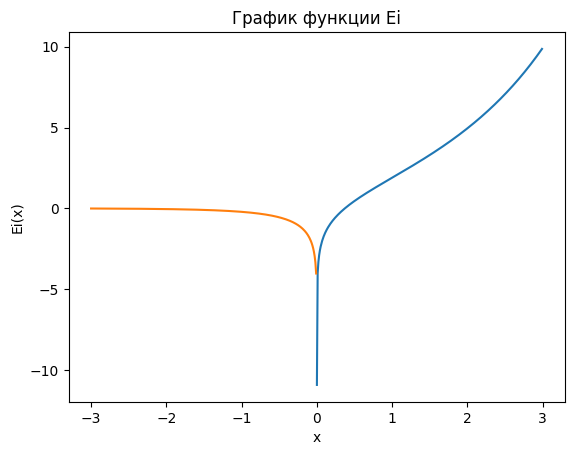

In [3]:
# для скорости и удобства используем sc.expi
# построим ветки функции для положительных и отрицательных аргументов раздельно
x = np.arange(1e-5,3,0.01)
x1 = np.arange(-3,-1e-5,0.01)

plt.plot(x, sc.expi(x))
plt.plot(x1, sc.expi(x1))
plt.title("График функции Ei")
plt.xlabel("x")
plt.ylabel("Ei(x)")
plt.show()

Для нас практический интерес будет представлять часть графика для отрицательных значений около нуля (красная линия). Для этой области хорошо работает логарифмическая аппроксимация.

Из выражения (11.8) для малых отрицательных значений аргумента можно получить
$$
Ei(-x) = \ln(x) + \gamma
\tag{11.19}
$$

где $\gamma = 0.57721566481$ - константа Эйлера

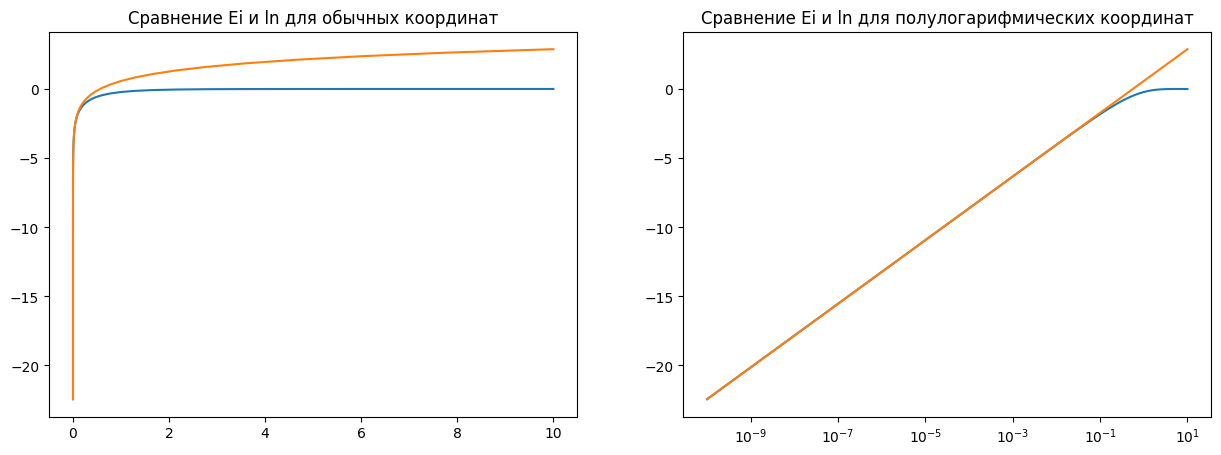

In [4]:
# зададим логарифмическое распределение точек вблизи нуля для построения графика
x = np.logspace(-10, 1, 100)

plt.rcParams["figure.figsize"] = (15,5)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, sc.expi(-x))
ax1.plot(x, np.log(x) + 0.57721566481)
ax1.set_title('Сравнение Ei и ln для обычных координат')

ax2.plot(x, sc.expi(-x))
ax2.plot(x, np.log(x)  + 0.57721566481)
ax2.set_xscale('log')
ax2.set_title('Сравнение Ei и ln для полулогарифмических координат')

plt.show()

Задавшить определенной точностью для константы Эйлера $\gamma$ (мы взяли около 10 значащих знаков после запятой) - можно построить зависимость ошибки аппроксимации функции $Ei$ при помощи $\ln$. Удобнее отобразить эту зависимость в двойных логарифмических координатах. По ней можно определить до какого значения аргумента - ошибка будет лежать в желаемом диапазоне.

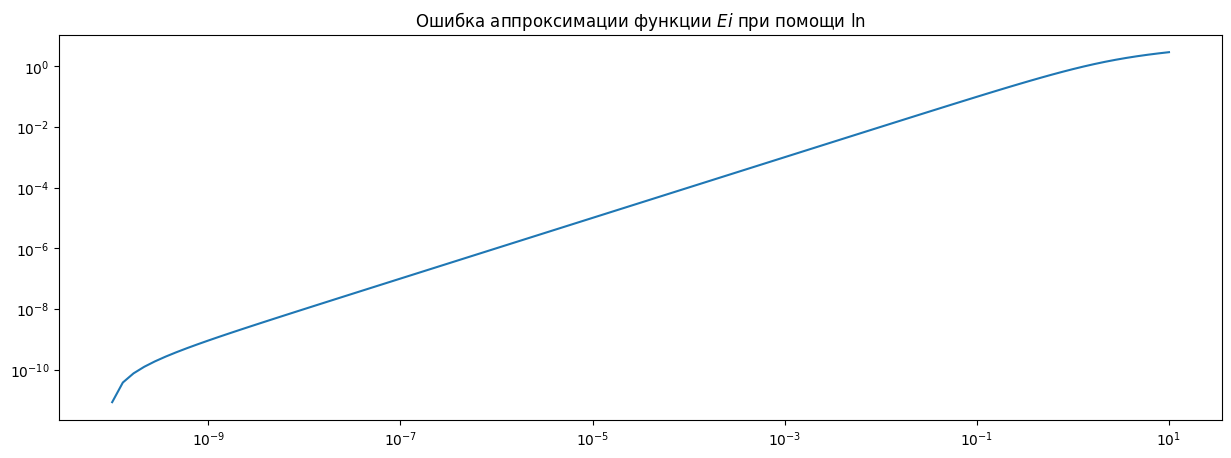

величина аргумента x = 1.01e-05 дает ошибку аппроксимации около 1.0099882965519669e-05


In [5]:
x = np.logspace(-10, 1, 100)

plt.rcParams["figure.figsize"] = (15,5)
fig, (ax1) = plt.subplots(1, 1)
ax1.plot(x, np.log(x) + 0.57721566481 - sc.expi(-x))
ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.set_ylim(1e-20, 1)
ax1.set_title('Ошибка аппроксимации функции $Ei$ при помощи $\ln$')

x = 1.01e-5
plt.show()
print('величина аргумента x = {} дает ошибку аппроксимации около {}'.format(x, np.log(x) + 0.57721566481 - sc.expi(-x)))

### 1.3.2 Решение линейного стока 

Решение линейного стока (с бесконечно малым радиусом скважины) можно представить в виде.

$$ 
p_D(r_D,t_D) = - \frac{1}{2} Ei \left(- \dfrac{ r_D^2}{4t_d} \right)
\tag{11.20}
\label{11.20}
$$

In [6]:
# Решение линейного стока уравнения фильтрации
def pd_ei(td, rd):
    """
    Решение линейного стока уравнения фильтрации
    rd - безразмерное расстояние
    td - безразмерное время
    """
    return -1/2*sc.expi(-rd**2 / 4 / td)

#### Построение графика решения от расстояния для произвольного момента времени в безразмерных координатах

Пример показывает как построить распределение давления для заданного момента времени. Помните что тут безразмерное давление и время. Для построения графика используется логарифмическое распределение значений расстояния, так как около нуля требуется больше точек для отображения из за значительного изменения функции.

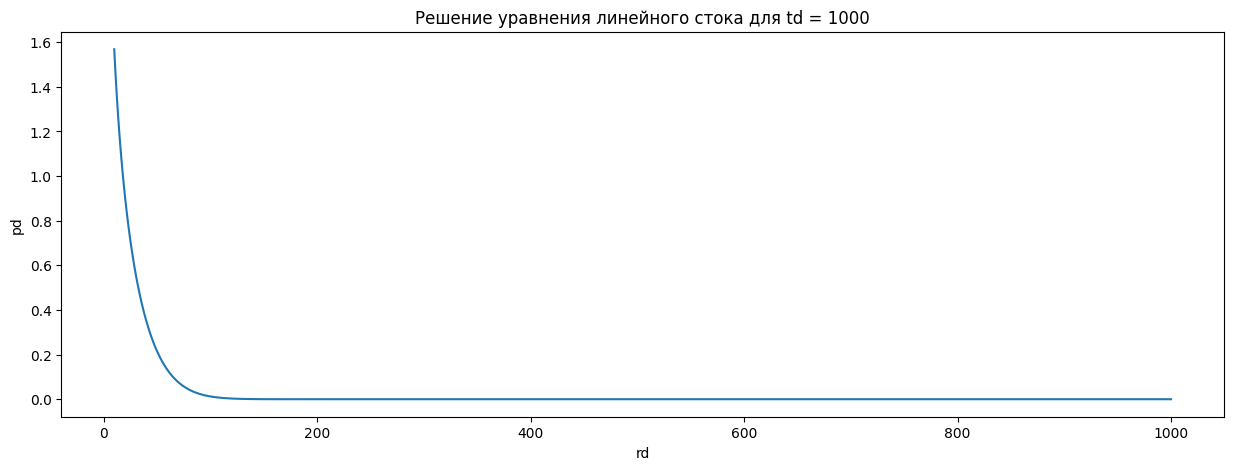

In [7]:
td = 1000
rd_arr = np.logspace(1, 3, 100)
# при построении используем векторный расчет
plt.plot(rd_arr, pd_ei(td, rd_arr) )
plt.title("Решение уравнения линейного стока для td = {}".format(td))
plt.xlabel("rd")
plt.ylabel("pd")
plt.show()

#### Построение графика решения от расстояния для произвольного момента времени в размерных координатах

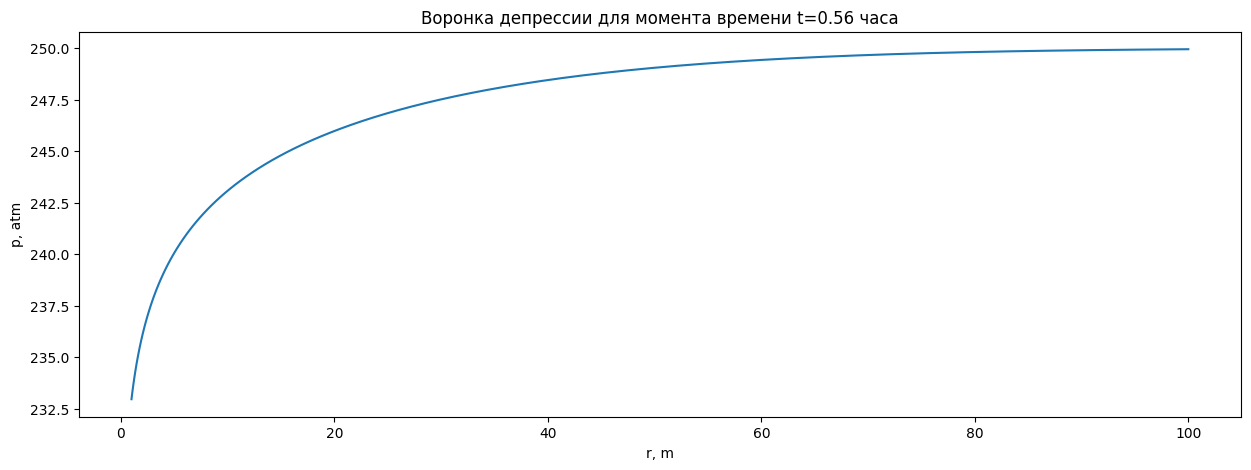

In [8]:
# построим решение для размерных величин
# при переводе величин в размерные полагаемся на значения параметров по умолчанию заданные 
# при определении переводных функций
td = 100000
rd_arr = np.logspace(1, 3, 100)
# для нагладности проведем преобразования в отдельные переменные. можно было сделать и на месте
# все преобразования и расчеты делаются векторно за счет использования numpy
r_arr = r_from_rd_m(rd_arr)
p_arr = p_from_pd_atma(pd_ei(td,rd_arr))
plt.plot(r_arr, p_arr )
plt.title("Воронка депрессии для момента времени t={:.2f} часа".format(t_from_td_hr(td)))
plt.xlabel("r, m")
plt.ylabel("p, atm")
plt.show()

Хорошо видна воронка депрессии. Если изменить значение времени и перестроить график можно убедиться, что решение будет меняться и воронка депресси будет менять свой размер. Убедиться в этом можно построить сразу много графиков

#### Сразу много решений для разных моментов времени

Мы можем зациклить расчет распределений давления, и сформировать много кривых на графике matplotlib и потом отобразить их. Получится прикольная картинка.

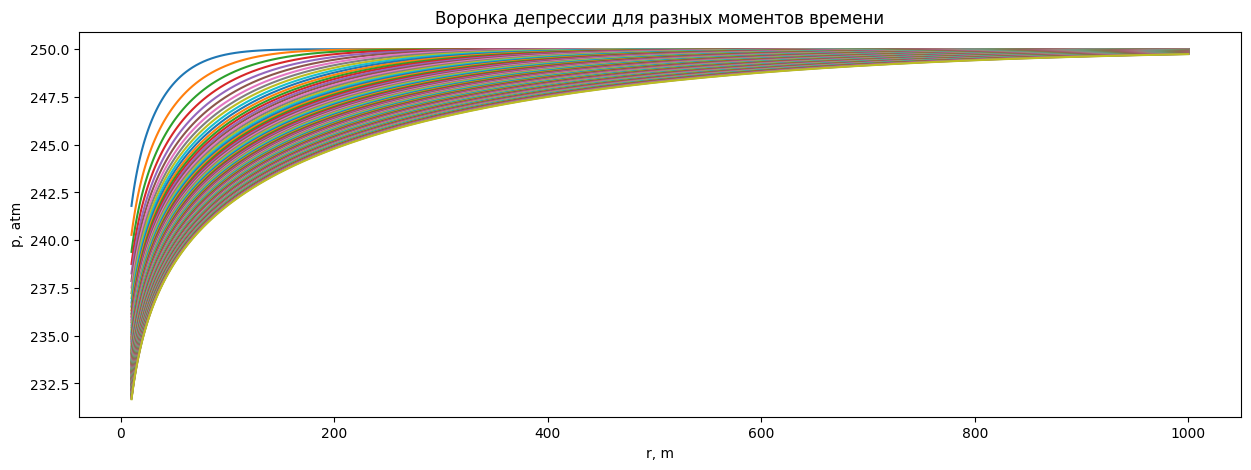

In [9]:
# Пример построения сразу нескольких решений на одном графике
# Зададим массив (итератор) определяющий количество графиков которые мы хотим построить
n=np.arange(1,100,1)
# зададим диапазон изменения расстояний и количество точек для которых строятся кривые
r_arr_m = np.logspace(1, 3, 100)

# цикл расчета. Полезно понимать тут, что функция Ei будет вызываться число раз равное
# произведению количества графиков на количество точек. 
# для сложных функций это время может оказаться достаточно заметным
for i in n:
    t_hr = 1*i
      # здесь используем расчет заполнения массива с использованием итератора python - 
      # не самый быстрый вариант для этой функции, но работает
    plt.plot(r_arr_m, [p_from_pd_atma(pd_ei(td_from_t(t_hr), rdi)) for rdi in rd_from_r(r_arr_m)])
plt.title("Воронка депрессии для разных моментов времени")
plt.xlabel("r, m")
plt.ylabel("p, atm")
plt.show()

На графике можно заметить, что со временем воронка депрессии расширяется. Это позволяет ввести понятие радиуса влияния скважины, которое будет обсуждаться позднее.

# 11.2. Задания для самостоятельной работы <a class="anchor" id="11.2"></a>

Для совершенствования навыков работы с python выполните следующие задания:

1. Постройте график распределения давления в пласте для композитного пласта. В композитном пласте на расстоянии $r<r_1$ проницаемость равна $k=k_1$, а для $r>=r_1$, $k=k_2$. Как будет меняться воронка депрессии в таком пласте со временем?
2. Постройте двумерную тепловую карту распределения давления в пласте для моделей однородного пласта и композитного пласта. 
3. Постройте график зависимости радиуса влияния скважины от времени.

# Список литературы

1. Kappa. Dynamic Data Analysis. The theory and practice of pressure transient, production analysis, well performance analysis, production logging and the use of permanent downhole gauge data. v4.12.02 Olivier Houze, Didier Viturat, Ole S. Fjare (et al)